In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gsp
import seaborn as sns

In [3]:
gene_sets = {gene_set: pd.read_excel('../data/Gene pool_H7N9.xls', sheet_name=gene_set) for gene_set in ['Set 1', 'Set 2']}
gene_sets['Set 1'].head()

,GeneID,GeneDescription,per OI,per LRT
0,CD177,CD177 molecule,-0.013355,0.998697
1,MMP9,matrix metallopeptidase 9,-0.012002,0.888065
2,ALPL,"alkaline phosphatase, liver/bone/kidney",-0.008771,0.673289
3,MGAM,maltase-glucoamylase,-0.009229,0.668396
4,MCEMP1,mast cell-expressed membrane protein 1,-0.008633,0.645316


In [15]:
enrichments = {}
for key, gs_df in gene_sets.items():
    gs_df = gs_df.sort_values('per OI')
    enrichment = gsp.enrichr(gene_list = gs_df.GeneID.tolist(),
                    gene_sets = 'KEGG_2016',
                    outdir='../Enrichr' ,format='png') \
            .res2d 
    enrichments[key] = enrichment

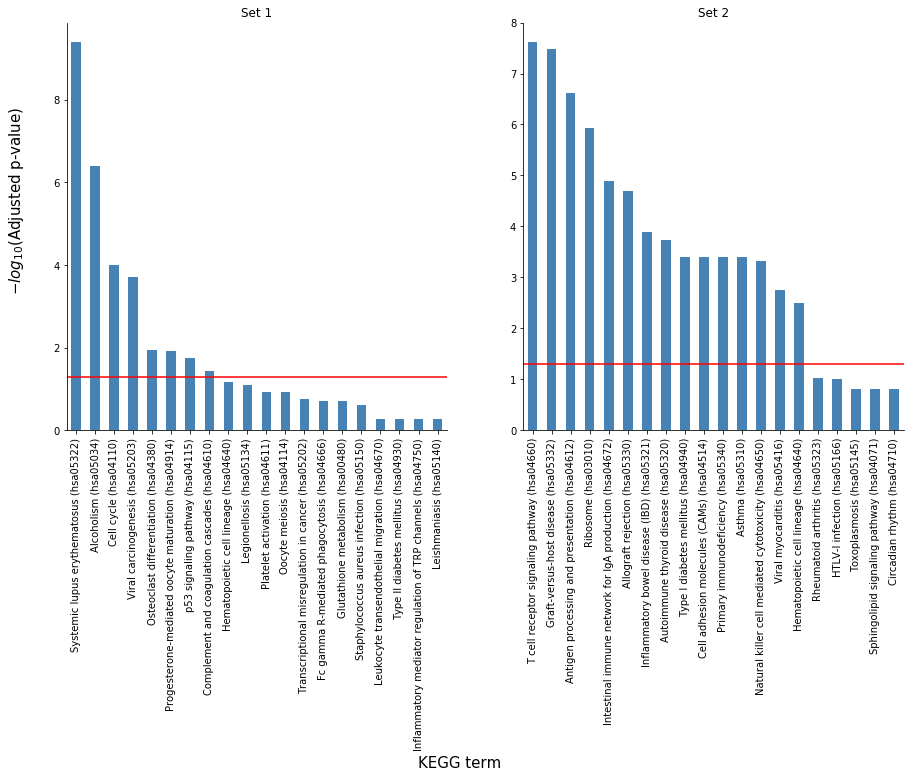

In [14]:
fig = plt.figure(figsize = (15,7.5))
for i, (gene_set, enr) in enumerate(enrichments.items()):
    ax = fig.add_subplot(1, 2, i + 1)
    enr\
        .reset_index()\
        .nsmallest(20,'Adjusted P-value')\
        .assign(log_p = lambda d: d['Adjusted P-value'].transform(lambda x: -np.log10(x)))\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot.bar('Term','log_p', ax = ax, 
              color = 'steelblue')
    ax.hlines(xmin = -1, xmax = 100, y = -np.log10(0.05), color = 'red')
    ax.set_title(gene_set)
    #ax.set_ylim(0,0.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.legend().set_visible(False)
sns.despine()
fig.text(0.07, 0.7, r'$-log_{10}$(Adjusted p-value)', size = 15, rotation= 90)
fig.text(0.45, -0.5, 'KEGG term', size = 15)
figurename = '../figures/kegg_enrichment.png'
fig.savefig(figurename, bbox_inches='tight', transparent = True)